In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn import metrics
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

### Reading Training data

In [2]:
df1=pd.read_csv("./processed/training/engaged.csv")
df2=pd.read_csv("./processed/training/notEngaged.csv")
dff=pd.read_csv("./TopFeatures.csv")

In [3]:
dft=pd.concat([df1,df2])

In [4]:
feat=dff.to_numpy()
feat=feat.reshape(-1)

In [5]:
print(feat)

[' AU12_c' ' AU04_c' ' AU12_r' ' AU04_r' ' AU05_c' ' AU14_c' ' AU06_c'
 ' AU06_r' ' AU14_r' ' AU07_r' ' p_8' ' AU10_c' ' p_2' ' AU10_r' ' p_0'
 ' p_23' ' p_7' ' p_6' ' p_10' ' AU01_r' ' AU25_r' ' p_24' ' p_12' ' p_11'
 ' AU17_r' ' AU09_r' ' AU26_r' ' p_9' ' AU45_r' ' p_20' ' AU05_r'
 ' AU23_r' ' p_13' ' p_19' ' p_33' ' gaze_angle_y' ' p_5' ' AU02_r'
 ' p_26' ' p_18' ' p_16' ' gaze_1_y' ' p_32' ' AU07_c' ' AU15_c' ' AU15_r'
 ' p_30' ' p_31' ' AU20_r' ' p_4']


In [6]:
y_train=dft["Result"]
x_train=dft.drop("Result",axis=1)
x_train=x_train[feat]

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



### Initialize model

In [8]:
model = tree.DecisionTreeClassifier()

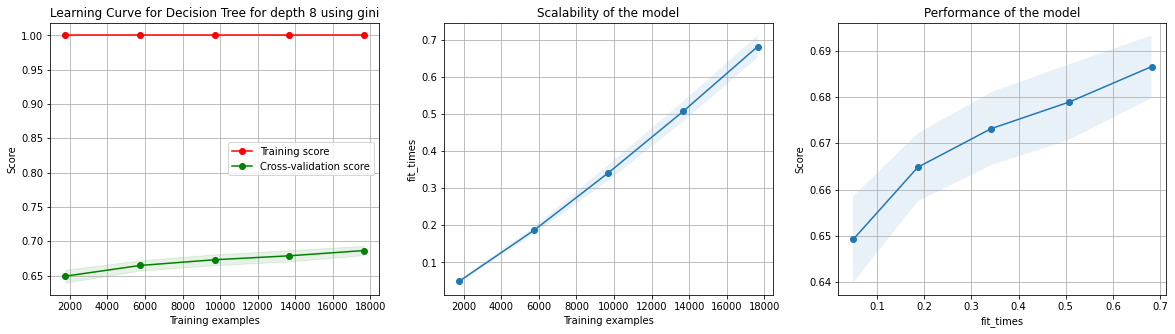

In [9]:
#fig, axes = plt.subplots(3, 1, figsize=(10, 15))


# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


title = "Learning Curve for Decision Tree for depth 8 using gini"
estimator = model
plot_learning_curve(estimator, title, x_train, y_train,
                    cv=cv, n_jobs=4)
plt.show()
plt.close()
    

### Score of the model with 100 folds

In [10]:
avg_score=cross_val_score(model,x_train, y_train, cv=100)

In [11]:
print(avg_score)
print(sum(avg_score)/100)

[0.71040724 0.70588235 0.74208145 0.70588235 0.71040724 0.64705882
 0.6199095  0.69683258 0.63348416 0.66515837 0.6561086  0.760181
 0.72850679 0.67873303 0.65158371 0.63348416 0.66063348 0.7239819
 0.66515837 0.66063348 0.65158371 0.69683258 0.62895928 0.56108597
 0.63348416 0.52036199 0.4841629  0.64253394 0.62443439 0.60180995
 0.59728507 0.53846154 0.53393665 0.54298643 0.52941176 0.54751131
 0.53393665 0.57466063 0.61538462 0.53846154 0.52941176 0.53393665
 0.44343891 0.59276018 0.54298643 0.47963801 0.52036199 0.5158371
 0.58371041 0.57466063 0.57466063 0.5158371  0.58823529 0.57013575
 0.57466063 0.67727273 0.68636364 0.71363636 0.68636364 0.73181818
 0.69545455 0.75       0.75909091 0.76818182 0.67727273 0.74090909
 0.73636364 0.74090909 0.70454545 0.66818182 0.75454545 0.80909091
 0.7        0.77272727 0.71818182 0.76363636 0.68181818 0.75909091
 0.73181818 0.75454545 0.71363636 0.72272727 0.8        0.81363636
 0.84090909 0.84090909 0.70909091 0.67727273 0.71818182 0.77727273

### Training of the given model

In [12]:
model = model.fit(x_train, y_train)

In [14]:
target_names = ['Not Engaged','Engaged']
print(classification_report(y_train,model.predict(x_train),target_names=target_names))

              precision    recall  f1-score   support

 Not Engaged       1.00      1.00      1.00      9834
     Engaged       1.00      1.00      1.00     12221

    accuracy                           1.00     22055
   macro avg       1.00      1.00      1.00     22055
weighted avg       1.00      1.00      1.00     22055



### Saving the Model

In [15]:
patho=r'./models'
joblib.dump(model, (os.path.join(patho,r''+'model_joblib_decision_tree')))

['./models/model_joblib_decision_tree']